##Importando bibliotecas

In [ ]:
import pandas as pd
import  numpy as np
import json
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from prefixspan import PrefixSpan

##Limpando e Estruturando a base de dados

O objetivo do trabalho é encontrar padrões frequentes em sequências de lances de futebol de um time que levam a um chute ao gol do time adversário. Com isso em mente, seguimos para a preparação e análise dos dados

In [2]:
path = "/mnt/c/Users/Lucas/Downloads/statsbomb/data/competitions.json"
comp = pd.read_json(path)

In [3]:
comp.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-06-12T07:44:38.559714,2021-06-13T16:17:31.694,None,2024-06-12T07:44:38.559714
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [4]:
comp['competition_name'].value_counts()

competition_name
Champions League           18
La Liga                    18
FIFA World Cup              8
Copa del Rey                3
Ligue 1                     3
FA Women's Super League     3
UEFA Euro                   2
1. Bundesliga               2
Women's World Cup           2
Liga Profesional            2
Serie A                     2
Premier League              2
African Cup of Nations      1
Copa America                1
Major League Soccer         1
FIFA U20 World Cup          1
Indian Super league         1
North American League       1
NWSL                        1
UEFA Europa League          1
UEFA Women's Euro           1
Name: count, dtype: int64

Para uma maior genarização da análise, iremos focar na competição copa do mundo que é uma competição internacional de futebol entre seleções masculinas organizada pela FIFA que reune 32 equipes nacionais e ocorre a cada quatro anos.

In [5]:
competition = "FIFA World Cup"
id = comp[comp["competition_name"] == competition].values[0][0]
print("id da Copa do Mundo: ", id)

id da Copa do Mundo:  43


Listando as temporadas da Copa do Mundo que são abrangidas pelos dados

In [6]:
comp[comp["competition_name"] == competition]["season_name"].values

array(['2022', '2018', '1990', '1986', '1974', '1970', '1962', '1958'],
      dtype=object)

Infelizmente essas são as únicas edições da competição que temos dados

Extraindo as partidas da copa do mundo, que estão no diretorio */matches/[id_competition]/*

In [7]:
path = "/mnt/c/Users/Lucas/Downloads/statsbomb/data/matches/43"
files = glob.glob(path + "/*.json")
files

['/mnt/c/Users/Lucas/Downloads/statsbomb/data/matches/43/106.json',
 '/mnt/c/Users/Lucas/Downloads/statsbomb/data/matches/43/269.json',
 '/mnt/c/Users/Lucas/Downloads/statsbomb/data/matches/43/270.json',
 '/mnt/c/Users/Lucas/Downloads/statsbomb/data/matches/43/272.json',
 '/mnt/c/Users/Lucas/Downloads/statsbomb/data/matches/43/3.json',
 '/mnt/c/Users/Lucas/Downloads/statsbomb/data/matches/43/51.json',
 '/mnt/c/Users/Lucas/Downloads/statsbomb/data/matches/43/54.json',
 '/mnt/c/Users/Lucas/Downloads/statsbomb/data/matches/43/55.json']

In [8]:
ids = []
for file in files:
    df = pd.read_json(file)
    ids.extend(df["match_id"].unique().astype(int).tolist())
print(ids)
print("Número de partidas: ", len(ids))

[3857256, 3869151, 3857257, 3857258, 3857288, 3857267, 3869321, 3857287, 3869486, 3869685, 3857260, 3857264, 3857266, 3857289, 3857269, 3857294, 3869254, 3869118, 3869684, 3869519, 3869354, 3869552, 3869420, 3869220, 3869219, 3869253, 3869152, 3869117, 3857270, 3857263, 3857259, 3857295, 3857283, 3857284, 3857282, 3857286, 3857301, 3857300, 3857299, 3857298, 3857297, 3857296, 3857293, 3857292, 3857291, 3857290, 3857285, 3857281, 3857280, 3857279, 3857278, 3857277, 3857276, 3857275, 3857274, 3857273, 3857272, 3857271, 3857268, 3857265, 3857262, 3857261, 3857255, 3857254, 3888705, 3888704, 3888854, 3889218, 3889217, 3888702, 3888701, 3888700, 3888699, 7585, 7570, 7586, 7557, 7542, 8656, 7554, 7550, 7548, 7578, 7553, 7544, 7536, 7555, 7546, 7539, 7538, 7576, 7565, 7551, 7537, 7580, 8650, 7581, 7549, 7529, 7534, 7562, 7571, 7569, 7568, 7530, 7558, 7583, 7547, 7535, 7584, 7545, 8649, 8658, 7561, 7531, 7582, 7552, 7532, 7560, 7533, 7564, 7579, 7572, 7577, 7543, 7525, 7566, 8651, 7567, 7541, 

Temos os ids de todas as partidas da Copa do Mundo, agora basta encontrar o arquivos dos eventos em json de cada partida no diretório */events/[id].json*

In [9]:
path = "/mnt/c/Users/Lucas/Downloads/statsbomb/data/events"
events = pd.DataFrame()
for id in ids:
    df = pd.read_json(path + "/" + str(id) + ".json")
    events = pd.concat([events, df])

In [10]:
events.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,block,foul_committed,ball_recovery,substitution,injury_stoppage,bad_behaviour,miscontrol,50_50,half_start,player_off
0,093f898d-33b1-4425-b591-37dd9c9bf70b,1,1,2025-02-20 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 786, 'name': 'Serbia'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79a9efbb-b5e5-45b0-983d-8729bcc4a0e1,2,1,2025-02-20 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 786, 'name': 'Serbia'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c4cdfc71-b9f4-4751-a714-e816c1419457,3,1,2025-02-20 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 786, 'name': 'Serbia'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,51f295b8-da96-428e-ab47-90f380f8cf53,4,1,2025-02-20 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 786, 'name': 'Serbia'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4acb4fd2-f46a-4d73-993c-e06597873924,5,1,2025-02-20 00:00:00.521,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 773, 'name': 'Switzerland'}","{'id': 9, 'name': 'From Kick Off'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524490 entries, 0 to 3139
Data columns (total 41 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               524490 non-null  object        
 1   index            524490 non-null  int64         
 2   period           524490 non-null  int64         
 3   timestamp        524490 non-null  datetime64[ns]
 4   minute           524490 non-null  int64         
 5   second           524490 non-null  int64         
 6   type             524490 non-null  object        
 7   possession       524490 non-null  int64         
 8   possession_team  524490 non-null  object        
 9   play_pattern     524490 non-null  object        
 10  team             524490 non-null  object        
 11  duration         360816 non-null  float64       
 12  tactics          674 non-null     object        
 13  related_events   501046 non-null  object        
 14  player           519855 non

Resetando a indexação

In [12]:
events = events.reset_index(drop=True)

Antes mesmo de realizar a EDA, irei fazer a remoção de colunas que são, logo de cara, desnecessárias para nossa análise e projeto

In [13]:
events = events[["minute", "second", "period", "possession", "possession_team","type", "shot"]]

In [14]:
events.head(50)

,minute,second,period,possession,possession_team,type,shot
0,0,0,1,1,"{'id': 786, 'name': 'Serbia'}","{'id': 35, 'name': 'Starting XI'}",NaN
1,0,0,1,1,"{'id': 786, 'name': 'Serbia'}","{'id': 35, 'name': 'Starting XI'}",NaN
2,0,0,1,1,"{'id': 786, 'name': 'Serbia'}","{'id': 18, 'name': 'Half Start'}",NaN
3,0,0,1,1,"{'id': 786, 'name': 'Serbia'}","{'id': 18, 'name': 'Half Start'}",NaN
4,0,0,1,2,"{'id': 773, 'name': 'Switzerland'}","{'id': 30, 'name': 'Pass'}",NaN
5,0,1,1,2,"{'id': 773, 'name': 'Switzerland'}","{'id': 42, 'name': 'Ball Receipt*'}",NaN
6,0,1,1,2,"{'id': 773, 'name': 'Switzerland'}","{'id': 43, 'name': 'Carry'}",NaN
7,0,3,1,2,"{'id': 773, 'name': 'Switzerland'}","{'id': 30, 'name': 'Pass'}",NaN
8,0,5,1,2,"{'id': 773, 'name': 'Switzerland'}","{'id': 42, 'name': 'Ball Receipt*'}",NaN
9,0,5,1,2,"{'id': 773, 'name': 'Switzerland'}","{'id': 43, 'name': 'Carry'}",NaN


Como se pode observar, os eventos estão ordenados em ordem de ocorrência e as colunas *possession_team*, *type* e *shot* possuem um tipo de dados hierárquico, por isso vamos extrair apenas o campo *name* dessas colunas

In [15]:
def get_name(data):
    if isinstance(data, dict):
        return data.get('name')
    return data

# Aplicar a função nas colunas desejadas
events['possession_team'] = events['possession_team'].apply(get_name)
events['type'] = events['type'].apply(get_name)
events.head(50)

,minute,second,period,possession,possession_team,type,shot
0,0,0,1,1,Serbia,Starting XI,NaN
1,0,0,1,1,Serbia,Starting XI,NaN
2,0,0,1,1,Serbia,Half Start,NaN
3,0,0,1,1,Serbia,Half Start,NaN
4,0,0,1,2,Switzerland,Pass,NaN
5,0,1,1,2,Switzerland,Ball Receipt*,NaN
6,0,1,1,2,Switzerland,Carry,NaN
7,0,3,1,2,Switzerland,Pass,NaN
8,0,5,1,2,Switzerland,Ball Receipt*,NaN
9,0,5,1,2,Switzerland,Carry,NaN


No começo a partida observa-se que os 2 primeiros eventos estão duplicados, mas não há necessidade de retirar eles agora.

Agora, darei mais atenção à coluna *shot*, irei extrair da coluna se o chute foi gol ou não criando um novo atributo *goal* e excluindo *shot*  

In [16]:
def get_outcome(shot_data):
    if isinstance(shot_data, dict):
        return shot_data.get('outcome')
    return None

events['shot_outcome'] = events['shot'].apply(get_outcome)

In [17]:
events.head(30)

,minute,second,period,possession,possession_team,type,shot,shot_outcome
0,0,0,1,1,Serbia,Starting XI,NaN,None
1,0,0,1,1,Serbia,Starting XI,NaN,None
2,0,0,1,1,Serbia,Half Start,NaN,None
3,0,0,1,1,Serbia,Half Start,NaN,None
4,0,0,1,2,Switzerland,Pass,NaN,None
5,0,1,1,2,Switzerland,Ball Receipt*,NaN,None
6,0,1,1,2,Switzerland,Carry,NaN,None
7,0,3,1,2,Switzerland,Pass,NaN,None
8,0,5,1,2,Switzerland,Ball Receipt*,NaN,None
9,0,5,1,2,Switzerland,Carry,NaN,None


In [18]:
events["shot_outcome"] = events["shot_outcome"].apply(get_name)
events["goal"] = events["shot_outcome"] == "Goal"
events.head(30)

,minute,second,period,possession,possession_team,type,shot,shot_outcome,goal
0,0,0,1,1,Serbia,Starting XI,NaN,None,False
1,0,0,1,1,Serbia,Starting XI,NaN,None,False
2,0,0,1,1,Serbia,Half Start,NaN,None,False
3,0,0,1,1,Serbia,Half Start,NaN,None,False
4,0,0,1,2,Switzerland,Pass,NaN,None,False
5,0,1,1,2,Switzerland,Ball Receipt*,NaN,None,False
6,0,1,1,2,Switzerland,Carry,NaN,None,False
7,0,3,1,2,Switzerland,Pass,NaN,None,False
8,0,5,1,2,Switzerland,Ball Receipt*,NaN,None,False
9,0,5,1,2,Switzerland,Carry,NaN,None,False


In [19]:
events = events.drop(columns=["shot", "shot_outcome"])

In [20]:
events["type"] = events["type"].replace("Ball Receipt*", "Ball Receipt")
events.head(50)

,minute,second,period,possession,possession_team,type,goal
0,0,0,1,1,Serbia,Starting XI,False
1,0,0,1,1,Serbia,Starting XI,False
2,0,0,1,1,Serbia,Half Start,False
3,0,0,1,1,Serbia,Half Start,False
4,0,0,1,2,Switzerland,Pass,False
5,0,1,1,2,Switzerland,Ball Receipt,False
6,0,1,1,2,Switzerland,Carry,False
7,0,3,1,2,Switzerland,Pass,False
8,0,5,1,2,Switzerland,Ball Receipt,False
9,0,5,1,2,Switzerland,Carry,False


Aparentemente a cada começo de um período, temos uma linha a mais duplicada desse evento. Precisamos remover essas linhas duplicadas

In [21]:
events.drop_duplicates(inplace=True)
events.head(5)

,minute,second,period,possession,possession_team,type,goal
0,0,0,1,1,Serbia,Starting XI,False
2,0,0,1,1,Serbia,Half Start,False
4,0,0,1,2,Switzerland,Pass,False
5,0,1,1,2,Switzerland,Ball Receipt,False
6,0,1,1,2,Switzerland,Carry,False


In [22]:
events['goal'].value_counts()

goal
False    510074
True        443
Name: count, dtype: int64

In [23]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510517 entries, 0 to 524488
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   minute           510517 non-null  int64 
 1   second           510517 non-null  int64 
 2   period           510517 non-null  int64 
 3   possession       510517 non-null  int64 
 4   possession_team  510517 non-null  object
 5   type             510517 non-null  object
 6   goal             510517 non-null  bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 27.8+ MB


Agora os dados estão prontos para analisarmos mais profundamente

#Análise exploratória dos dados

* Dados numéricos

In [24]:
events.describe()

,minute,second,period,possession
count,510517.000000,510517.000000,510517.000000,510517.000000
mean,46.965004,29.351704,1.539400,90.168780
std,28.080394,17.342758,0.577891,54.096142
min,0.000000,0.000000,1.000000,1.000000
25%,23.000000,14.000000,1.000000,44.000000
50%,46.000000,29.000000,2.000000,87.000000
75%,70.000000,44.000000,2.000000,132.000000
max,128.000000,59.000000,5.000000,274.000000


Existem partidas que duraram mais do que 90 minutos, tiveram a prorrogação de mais 2 tempos de 15 minutos cada, vamos analisar isso mais a fundo analisando a distribuição de *period*/tempo e *minute*



---



In [25]:
events.head(5)

,minute,second,period,possession,possession_team,type,goal
0,0,0,1,1,Serbia,Starting XI,False
2,0,0,1,1,Serbia,Half Start,False
4,0,0,1,2,Switzerland,Pass,False
5,0,1,1,2,Switzerland,Ball Receipt,False
6,0,1,1,2,Switzerland,Carry,False


1) period

In [26]:
events["period"].value_counts()

period
1    251368
2    248347
3      5561
4      5060
5       181
Name: count, dtype: int64

Temos uma distribuição equilibrada de lances entre 1° e 2° tempo.

Tivemos partidas que foram para o *period* 5, que são cobranças de pênaltis. Vamos excluir essas cobranças pois elas são casos extremos de shot/chute e que não estamos interessados em analisar.

Eventos na prorrogação iremos manter na base.

In [27]:
indexs = events[events["period"] == 5].index
events = events.drop(indexs)
events["period"].value_counts()

period
1    251368
2    248347
3      5561
4      5060
Name: count, dtype: int64

- Qual tempo/periodo ocorre mais finalizações?

In [28]:
shots = events[events["type"] == "Shot"]
shots["period"].value_counts(normalize = True) * 100

period
2    53.483499
1    44.106862
4     1.388161
3     1.021477
Name: proportion, dtype: float64

53% dos chutes ocorreram no segundo tempo

- Qual tempo/periodo ocorre mais gols?

In [29]:
goals = events[events["goal"] == True]
goals["period"].value_counts(normalize = True) * 100

period
2    60.102302
1    38.107417
4     1.278772
3     0.511509
Name: proportion, dtype: float64

60% dos gols ocorreram no segundo período



---



2) minute

- Qual a distribuição temporal dos eventos

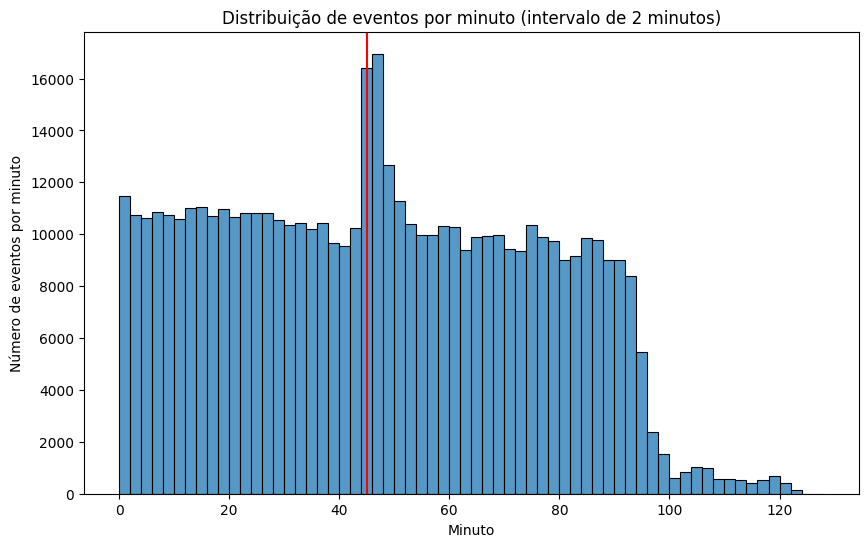

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(events['minute'], bins=np.arange(0, 130, 2), kde=False)
plt.xlabel('Minuto')
plt.ylabel('Número de eventos por minuto')
plt.title('Distribuição de eventos por minuto (intervalo de 2 minutos)')
plt.axvline(x=45, color='r', linestyle='-')
plt.show()

Esse pico no centro(aprox. 45 minutos) é o começo do segundo período

- Quais são os minutos mais comuns em que os chutes ocorrem?

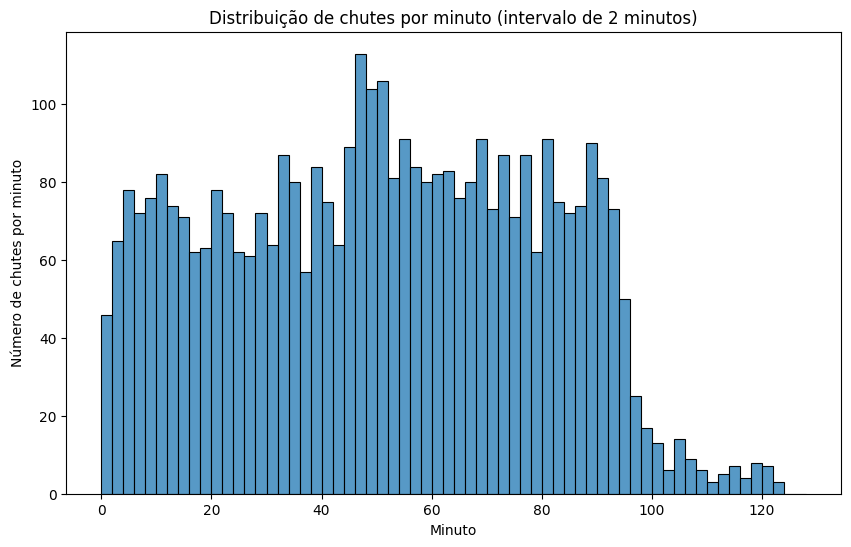

In [31]:
shots = events[events["type"] == "Shot"]
plt.figure(figsize=(10, 6))
sns.histplot(shots['minute'], bins=np.arange(0, 130, 2), kde=False)
plt.xlabel('Minuto')
plt.ylabel('Número de chutes por minuto')
plt.title('Distribuição de chutes por minuto (intervalo de 2 minutos)')
plt.show()

- Quais são os minutos mais comuns em que os gols ocorrem?

Text(0, 0.5, 'Número de gols por minuto')

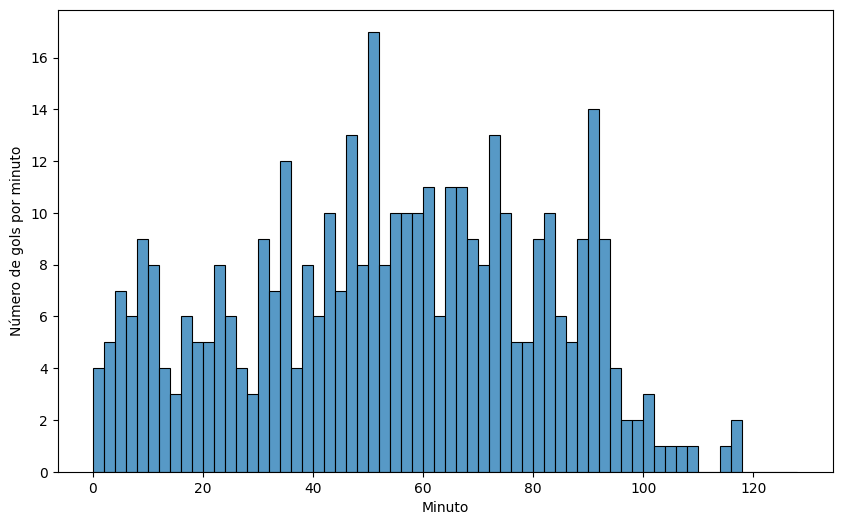

In [32]:
goals = events[events["goal"] == True]
plt.figure(figsize=(10, 6))
sns.histplot(goals['minute'], bins=np.arange(0, 130, 2), kde=False)
plt.xlabel('Minuto')
plt.ylabel('Número de gols por minuto')



---



- Verificação de outliers

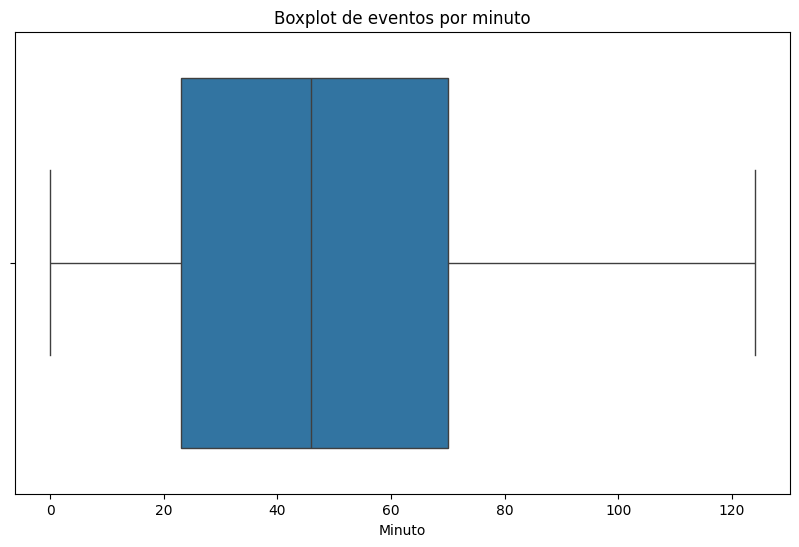

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=events['minute'])
plt.xlabel('Minuto')
plt.title('Boxplot de eventos por minuto')
plt.show()

In [34]:
events['zscore_minute'] = (events['minute'] - events['minute'].mean()) / events['minute'].std()
outliers = events[events['zscore_minute'].abs() > 3]

print(outliers[['minute', 'zscore_minute']])


Empty DataFrame
Columns: [minute, zscore_minute]
Index: []


Não temos outliers com partidas muito longas

In [35]:
events = events.drop(columns=["zscore_minute"])



---



3) possession

- Qual é a duração média de uma posse de bola em segundos

In [36]:
possesssion_time = []
previous_possession = 0
previous_time = 0
start_time = 0
for row in events.iterrows():
    time = row[1]["minute"] * 60 + row[1]["second"]

    if row[1]["possession"] != previous_possession: ## Troca de posse
        if previous_possession != 0:
            if(time - start_time > 0):
                possesssion_time.append(time - start_time)

        previous_possession = row[1]["possession"]
        start_time = time

    elif row[1]["type"] == "Half End": ## Fim do período
        possesssion_time.append(time - start_time)
        previous_possession = 0
        previous_time = 45

    else:
        previous_time = time

print("Número de sequências:\t", len(possesssion_time))
print("mínimo:\t", min(possesssion_time), "\nmedia:\t", np.mean(possesssion_time), "\nmáximo:\t", max(possesssion_time))

Número de sequências:	 26545
mínimo:	 1 
media:	 33.334676963646636 
máximo:	 508


Text(0.5, 0, 'tempo de posse em segundos')

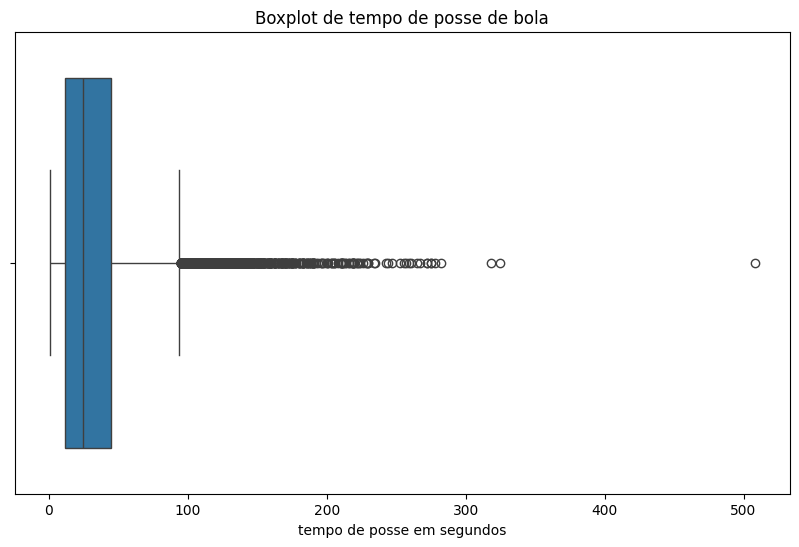

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=possesssion_time)
plt.title('Boxplot de tempo de posse de bola')
plt.xlabel('tempo de posse em segundos')

Presença de outliers significativa de posses de bola muito longas

In [38]:
q1 = np.quantile(possesssion_time, 0.25)
q3 = np.quantile(possesssion_time, 0.75)
iqr = q3 - q1

lower_bound = 1
upper_bound = q3 + 1.5 * iqr

outliers = [x for x in possesssion_time if x < lower_bound or x > upper_bound]
print("Número de outliers: ", len(outliers))

Número de outliers:  1198


Decidimos manter as posses de bola longas na análise, pois elas podem representar padrões estratégicos relevantes no jogo. Alguns times adotam um estilo de posse prolongada antes de finalizar, como o tiki-taka do Barcelona ou o jogo de controle do Manchester City. Remover esses outliers poderia distorcer a identificação de sequências de ações que levam a finalizações, eliminando padrões importantes. Para garantir uma análise equilibrada, podemos segmentar os dados em posses curtas e longas, permitindo comparar diferentes estratégias e identificar quais levam a finalizações mais eficazes.

1- Distruibuição do tempo de posse de bola

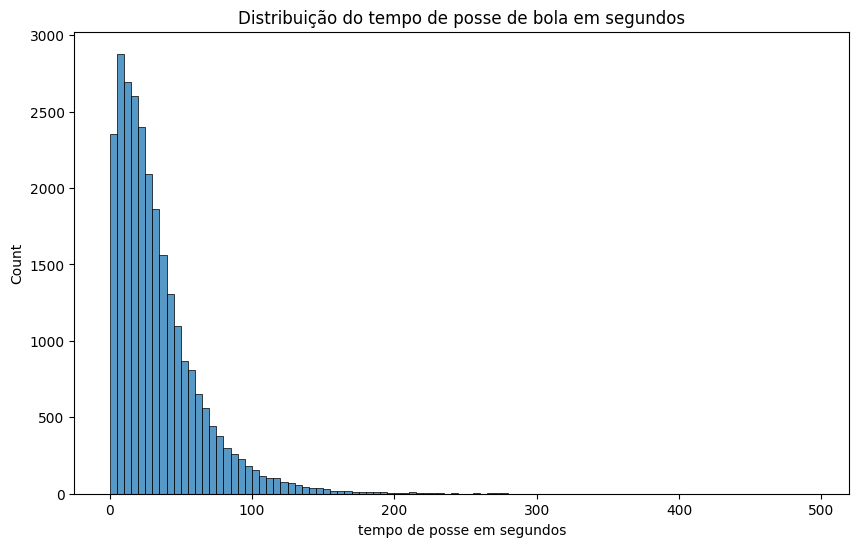

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(possesssion_time, bins=np.arange(0, 500, 5), kde=False)
plt.xlabel('tempo de posse em segundos')
plt.title('Distribuição do tempo de posse de bola em segundos')
plt.show()

- Qual o numero de lances médios até que a posse de bola seja trocada na partida?

In [40]:
events_count = []
previous_possession = 0
count = 0
for row in events.iterrows():
    if row[1]["possession"] != previous_possession or row[1]["type"] == "Half end": ## Troca de posse ou fim do período
        if previous_possession != 0:
          events_count.append(count)
        count = 1
        previous_possession = row[1]["possession"]
    else:
        count += 1

print("Número se sequências: ", len(events_count))
print("mínimo: ", min(events_count), "\nmedia: ", np.mean(events_count), "\nmáximo: ", max(events_count))

Número se sequências:  26636
mínimo:  1 
media:  19.15880762877309 
máximo:  258


Número máximo de eventos consecutivos muito alto.

In [41]:
events_count = np.array(events_count)
print("Número de sequências: ", events_count.shape[0])
print("Sequências com mais de 100 lances: ", events_count[events_count > 100].size)

Número de sequências:  26636
Sequências com mais de 100 lances:  217


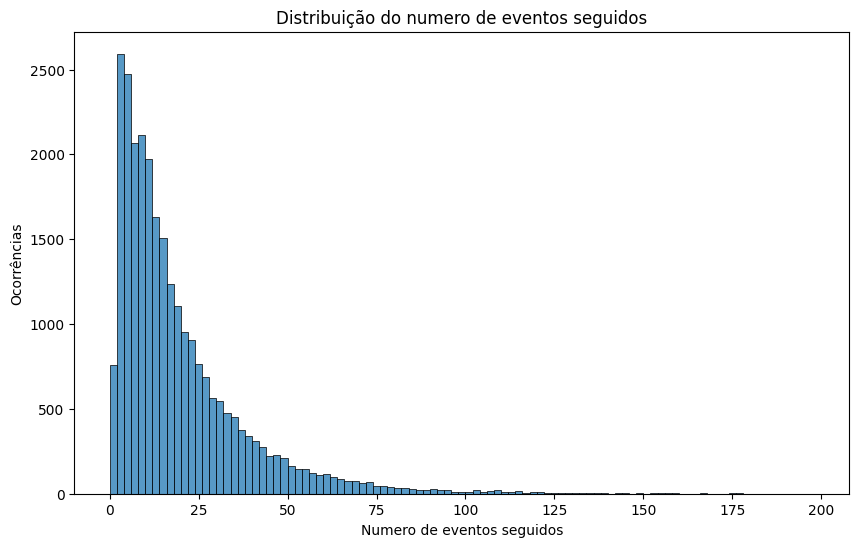

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(events_count, bins=np.arange(0, 200, 2), kde=False)
plt.xlabel('Numero de eventos seguidos')
plt.ylabel('Ocorrências')
plt.title('Distribuição do numero de eventos seguidos')
plt.show()



---



- Dados categóricos

1) type

Distribuição dos tipos de eventos

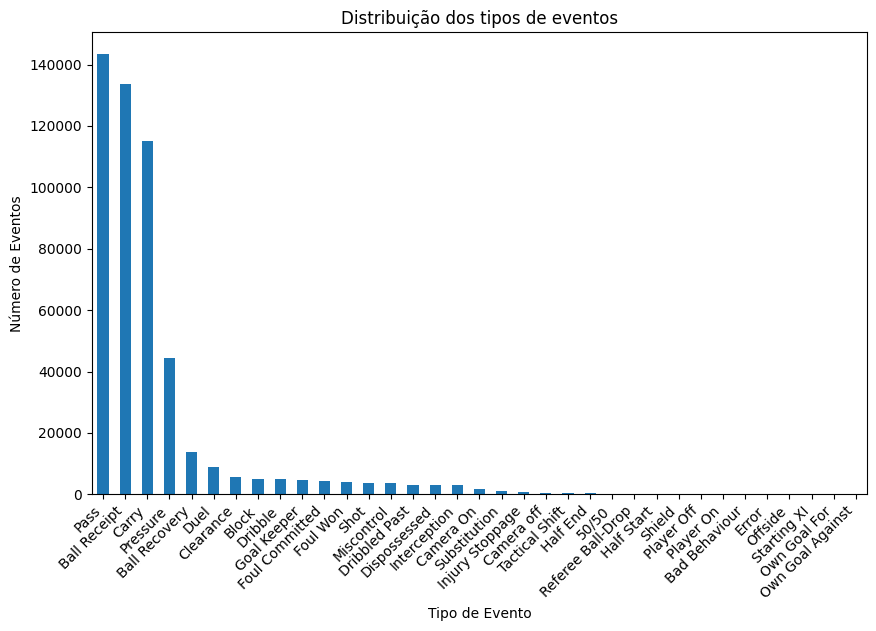

In [43]:
plt.figure(figsize=(10, 6))
events['type'].value_counts().plot(kind='bar')
plt.title('Distribuição dos tipos de eventos')
plt.xlabel('Tipo de Evento')
plt.ylabel('Número de Eventos')
plt.xticks(rotation=45, ha='right')
plt.show()

Essa distribuição dos tipos de lances no dataset revela que a maioria das ações registradas em uma partida de futebol estão relacionadas à circulação da bola, com passes, recepções de bola e conduções sendo os eventos mais frequentes. Isso reflete a dinâmica do jogo, onde a posse e movimentação da bola são predominantes. Eventos defensivos, como pressão, recuperação de bola e cortes, aparecem em menor quantidade, mas ainda representam um volume significativo. Já eventos mais pontuais, como finalizações, gols e faltas cometidas, são muito menos frequentes, o que é esperado, pois são momentos críticos e menos recorrentes dentro de um jogo. Essa distribuição sugere que a análise de padrões deve considerar principalmente sequências de passes e movimentações, pois esses eventos têm maior representatividade na construção das jogadas que levam a finalizações.

2) shot e goal

In [45]:
freq = events["type"].value_counts()
porcent = events["goal"].sum() / freq["Shot"] * 100
print("Percentual de gols por chute: ", porcent)

Percentual de gols por chute:  10.240963855421686


3) team

In [48]:
events['possession_team'].value_counts(normalize=True) * 100

possession_team
Brazil            8.187547
Argentina         6.212770
Croatia           5.617671
England           5.451506
France            5.083318
Spain             4.770191
Belgium           4.069476
Netherlands       3.640151
Germany           3.631333
Portugal          3.404424
Switzerland       2.833231
Morocco           2.769940
Uruguay           2.745250
Mexico            2.620039
Japan             2.477975
Denmark           2.475036
Australia         2.112530
Saudi Arabia      2.068637
Poland            2.051590
South Korea       2.022785
Tunisia           1.925202
Senegal           1.896006
Serbia            1.856032
Sweden            1.619521
United States     1.498816
Costa Rica        1.463742
Colombia          1.429646
Peru              1.370274
Russia            1.283860
Iran              1.231346
Canada            1.111033
Ecuador           0.986213
Qatar             0.922334
Nigeria           0.918806
Egypt             0.911752
Wales             0.904306
Ghana       

In [50]:
events.to_json("processado.json", orient='records', lines=True)